In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

/storage/home/hcocice1/anair319/.conda/envs/sp/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /lib64/libz.so.1: version `ZLIB_1.2.9' not found (required by /storage/home/hcocice1/anair319/.conda/envs/sp/lib/python3.9/site-packages/torchvision/../../../libpng16.so.16)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
load_from_chkpt = True # Load from checkpoint in case of resuming training

In [4]:
transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transform_blur = transforms.Compose([
                                     transforms.Resize((8,8)),
                                     transforms.Resize((32,32),interpolation=InterpolationMode.BILINEAR),
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# CIFAR 10 Dataset
train_dataset_clean = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

train_dataset_blur = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform_blur,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 128

train_loader_clean = torch.utils.data.DataLoader(dataset=train_dataset_clean,
                                           batch_size=batch_size, 
                                           shuffle=True)

train_loader_blur = torch.utils.data.DataLoader(dataset=train_dataset_blur,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
# def imshow(img, fig_title):
#     # img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg.squeeze()))
#     plt.title(fig_title)
#     plt.show()
    


# # get some random training images and show
# dataiter_blur = iter(train_loader_blur)
# images_blur, labels_blur = dataiter_blur.next()
# imshow(torchvision.utils.make_grid(images_blur), "Blurred images")
# # print(' '.join(f'{classes[labels_blur[j]]:5s}' for j in range(batch_size)))

# dataiter_clean = iter(train_loader_clean)
# images_clean, labels_clean = dataiter_clean.next()
# imshow(torchvision.utils.make_grid(images_clean), "Clean images")
# # print(' '.join(f'{classes[labels_clean[j]]:5s}' for j in range(batch_size)))

In [7]:
class AllCNNNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.dp0 = nn.Dropout2d(p = 0.2)
    self.conv1 = nn.Conv2d(3, 96, 3, padding=1)
    self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
    self.conv3 = nn.Conv2d(96, 192, 3, stride=2, padding=1)
    self.dp1 = nn.Dropout2d(p = 0.5)
    self.conv4 = nn.Conv2d(192, 192, 3, padding=1)
    self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
    self.conv6 = nn.Conv2d(192, 192, 3, stride=2, padding=1)
    self.dp2 = nn.Dropout2d(p = 0.5)
    self.conv7 = nn.Conv2d(192, 192, 3, padding=0)
    self.conv8 = nn.Conv2d(192, 192, 1)
    self.conv9 = nn.Conv2d(192, 10, 1)
    self.avg = nn.AvgPool2d(6)

    nn.init.xavier_normal_(self.conv1.weight)
    nn.init.xavier_normal_(self.conv2.weight)
    nn.init.xavier_normal_(self.conv3.weight)
    nn.init.xavier_normal_(self.conv4.weight)
    nn.init.xavier_normal_(self.conv5.weight)
    nn.init.xavier_normal_(self.conv6.weight)
    nn.init.xavier_normal_(self.conv7.weight)
    nn.init.xavier_normal_(self.conv8.weight)
    nn.init.xavier_normal_(self.conv9.weight)

  def forward(self, x):
    x = self.dp0(x)
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.dp1(x)
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.dp2(x)
    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x))
    x = F.relu(self.conv9(x))
    x = self.avg(x)
    x = torch.squeeze(x)
    # x = F.softmax(x, dim=0)
    return x

net = AllCNNNet().to(device)

In [8]:
# class AllCNNNet(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16*5*5, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 10)

#   def forward(self, x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     x = torch.flatten(x, 1)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

# net = AllCNNNet().to(device)

In [9]:
# Hyper-parameters
num_epochs_blur = 80
num_epochs_clean = 160
learning_rate = 0.05

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
# from torchsummary import summary

# summary(net, (3, 32, 32))

In [12]:
# For updating learning rate
def update_lr(optimizer, lr):    
#     print ("Updating LR")
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
num_epochs = num_epochs_blur + num_epochs_clean
total_step = len(train_loader_clean)
curr_lr = learning_rate
loss_plot = []
accuracy_plot = []
epoch_chkpt = 0

if(load_from_chkpt):
  # Load model from checkpoint
  path_chkpt = "./chkpt_1/model.pt"
  loss_plot_chkpt = "./chkpt_1/loss_plot.npy"
  acc_plot_chkpt = "./chkpt_1/acc_plot.npy"
  model = net
#   optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9, nesterov=True)

  checkpoint = torch.load(path_chkpt)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_chkpt = checkpoint['epoch']
  loss = checkpoint['loss']
  curr_lr = checkpoint['curr_lr']
  loss_plot = np.append(loss_plot, np.load(loss_plot_chkpt))
  accuracy_plot = np.append(accuracy_plot, np.load(acc_plot_chkpt))

  model.train()
  print("!!!Loaded from checkpoint!!! Epoch:{} Loss:{} curr_lr:{}".format(epoch_chkpt, loss, curr_lr))

for epoch in range(epoch_chkpt, num_epochs):  # loop over the dataset multiple times
  if epoch < num_epochs_blur:
    train_loader = train_loader_blur
    print("Using blur")
  else:
    train_loader = train_loader_clean
    print("Using clean")

  # running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      # zero the parameter gradients
      optimizer.zero_grad()
      loss.backward()


      optimizer.step()
      loss_plot = np.append(loss_plot, loss.item())

      if (i+1) % 100 == 0:
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f} LR: {:.4f}"
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(), curr_lr))

  # Decay learning rate
  curr_lr = 0.97 * curr_lr
  update_lr(optimizer, curr_lr)

  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy_temp = 100 * correct // total
  print(f'Accuracy of the network : {accuracy_temp} %')
  accuracy_plot = np.append(accuracy_plot, accuracy_temp)

  if (epoch+1)==2 or (epoch+1)%25==0:
    # Save model checkpoint
    epoch_chkpt = epoch+1
    path_chkpt = "./chkpt_1/model.pt"
    loss_plot_chkpt = './chkpt_1/loss_plot.npy'
    acc_plot_chkpt = './chkpt_1/acc_plot.npy'
    loss_chkpt = loss.item()

    torch.save({
                'epoch': epoch_chkpt,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_chkpt,
                'curr_lr': curr_lr,
                }, path_chkpt)
    np.save(loss_plot_chkpt, loss_plot)
    np.save(acc_plot_chkpt, accuracy_plot)
    print('!!!Checkpoint saved!!!')

print('Finished Training')

!!!Loaded from checkpoint!!! Epoch:225 Loss:0.5013872981071472 curr_lr:5.2797117707593594e-05
Using clean
Epoch [226/240], Step [100/391] Loss: 0.5488 LR: 0.0001
Epoch [226/240], Step [200/391] Loss: 0.5301 LR: 0.0001
Epoch [226/240], Step [300/391] Loss: 0.5070 LR: 0.0001
Accuracy of the network : 78 %
Using clean
Epoch [227/240], Step [100/391] Loss: 0.4571 LR: 0.0001
Epoch [227/240], Step [200/391] Loss: 0.4598 LR: 0.0001
Epoch [227/240], Step [300/391] Loss: 0.5652 LR: 0.0001
Accuracy of the network : 78 %
Using clean
Epoch [228/240], Step [100/391] Loss: 0.5692 LR: 0.0000
Epoch [228/240], Step [200/391] Loss: 0.5698 LR: 0.0000
Epoch [228/240], Step [300/391] Loss: 0.6411 LR: 0.0000
Accuracy of the network : 77 %
Using clean
Epoch [229/240], Step [100/391] Loss: 0.6722 LR: 0.0000
Epoch [229/240], Step [200/391] Loss: 0.5430 LR: 0.0000
Epoch [229/240], Step [300/391] Loss: 0.6565 LR: 0.0000
Accuracy of the network : 78 %
Using clean
Epoch [230/240], Step [100/391] Loss: 0.4421 LR: 0

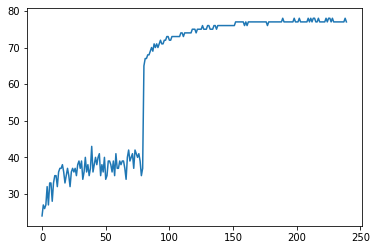

In [14]:
plt.plot(accuracy_plot)
plt.show()

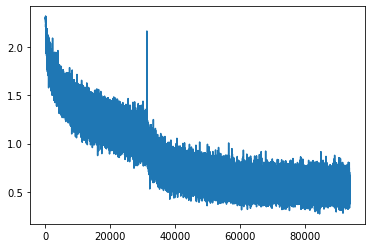

In [15]:
plt.plot(loss_plot)
plt.show()

In [16]:
PATH = './cifar_net_1.pth'
torch.save(net.state_dict(), PATH)

In [17]:
np.save('./acc_1.npy', accuracy_plot)
np.save('./loss_1.npy', loss_plot)

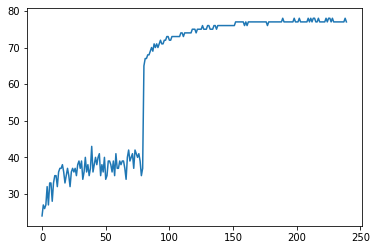

In [18]:
acc_data = np.load('./acc_1.npy')
plt.plot(acc_data)
plt.show()

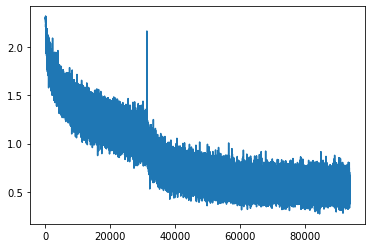

In [19]:
loss_data = np.load('./loss_1.npy')
plt.plot(loss_data)
plt.show()

In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 81.6 %
Accuracy for class: car   is 87.1 %
Accuracy for class: bird  is 69.2 %
Accuracy for class: cat   is 60.3 %
Accuracy for class: deer  is 76.1 %
Accuracy for class: dog   is 66.8 %
Accuracy for class: frog  is 81.7 %
Accuracy for class: horse is 80.7 %
Accuracy for class: ship  is 88.9 %
Accuracy for class: truck is 84.9 %


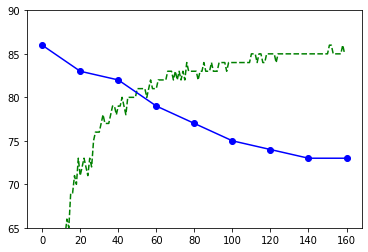

In [25]:
acc_data = np.load('./acc.npy')
acc_deficits = [86, 83, 82, 79, 77, 75, 74, 73, 73]
deficits = [0, 20, 40, 60, 80, 100, 120, 140, 160]
plt.plot(acc_data,'--g')
plt.plot(deficits, acc_deficits, 'o-b')
plt.ylim(65, 90)
plt.show()